In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [16]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv')


In [17]:
df = pd.read_csv('car_fuel_efficiency.csv')
df

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369
...,...,...,...,...,...,...,...,...,...,...,...
9699,140,5.0,164.0,2981.107371,17.3,2013,Europe,Diesel,Front-wheel drive,NaN,15.101802
9700,180,NaN,154.0,2439.525729,15.0,2004,USA,Gasoline,All-wheel drive,0.0,17.962326
9701,220,2.0,138.0,2583.471318,15.1,2008,USA,Diesel,All-wheel drive,-1.0,17.186587
9702,230,4.0,177.0,2905.527390,19.4,2011,USA,Diesel,Front-wheel drive,1.0,15.331551


In [23]:
df.columns

Index(['engine_displacement', 'num_cylinders', 'horsepower', 'vehicle_weight',
       'acceleration', 'model_year', 'origin', 'fuel_type', 'drivetrain',
       'num_doors', 'fuel_efficiency_mpg'],
      dtype='object')

In [21]:
categorical = ['origin', 'fuel_type', 'drivetrain']
numeric = ['engine_displacement', 'num_cylinders', 'horsepower', 'vehicle_weight', 'acceleration', 'model_year', 'num_doors', 'fuel_efficiency_mpg']

df[categorical] = df[categorical].fillna('NA')
df[numeric] = df[numeric].fillna(0)

In [40]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']


In [26]:
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [27]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

feature = dv.get_feature_names_out()[dt.tree_.feature[0]]
print("Feature used for split:", feature)


Feature used for split: vehicle_weight


In [28]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("RMSE:", rmse)


RMSE: 0.4595777223092726


In [38]:
scores = []
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append((n, rmse))
    print(f"n_estimators={n}, RMSE={rmse:.4f}")

n_estimators=10, RMSE=0.4596
n_estimators=20, RMSE=0.4536
n_estimators=30, RMSE=0.4517
n_estimators=40, RMSE=0.4487
n_estimators=50, RMSE=0.4467
n_estimators=60, RMSE=0.4455
n_estimators=70, RMSE=0.4451
n_estimators=80, RMSE=0.4450
n_estimators=90, RMSE=0.4449
n_estimators=100, RMSE=0.4447
n_estimators=110, RMSE=0.4436
n_estimators=120, RMSE=0.4439
n_estimators=130, RMSE=0.4437
n_estimators=140, RMSE=0.4434
n_estimators=150, RMSE=0.4429
n_estimators=160, RMSE=0.4428
n_estimators=170, RMSE=0.4428
n_estimators=180, RMSE=0.4424
n_estimators=190, RMSE=0.4425
n_estimators=200, RMSE=0.4425



RMSE stops improving at: 60 estimators


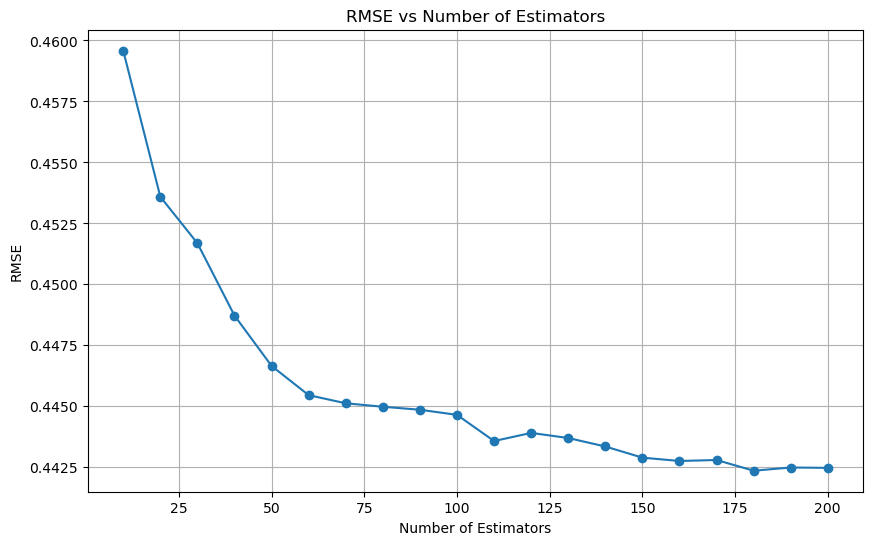

In [39]:
improvement_stopped = False
for i in range(1, len(scores)):
    if round(scores[i][1], 3) >= round(scores[i-1][1], 3):
        print("\nRMSE stops improving at:", scores[i-1][0], "estimators")
        improvement_stopped = True
        break

if not improvement_stopped:
    print("\nRMSE continued to improve up to 200 estimators")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot([s[0] for s in scores], [s[1] for s in scores], marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('RMSE')
plt.title('RMSE vs Number of Estimators')
plt.grid(True)
plt.show()

In [52]:
max_depths = [10, 15, 20, 25]
n_estimators_range = range(10, 210, 10)
results = {}

for depth in max_depths:
    rmse_scores = []
    for n in n_estimators_range:
        rf = RandomForestRegressor(
            n_estimators=n,
            max_depth=depth,
            random_state=1,
            n_jobs=-1
        )
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)
    
    mean_rmse = np.mean(rmse_scores)
    results[depth] = mean_rmse
    print(f"max_depth={depth}, mean RMSE={mean_rmse:.3f}")

best_depth = min(results.items(), key=lambda x: x[1])[0]
print(f"\nBest max_depth: {best_depth}")

max_depth=10, mean RMSE=0.442
max_depth=15, mean RMSE=0.445
max_depth=20, mean RMSE=0.446
max_depth=25, mean RMSE=0.446

Best max_depth: 10


In [55]:
rf = RandomForestRegressor(
    n_estimators=10,
    max_depth=20,
    random_state=1,
    n_jobs=-1
)
rf.fit(X_train, y_train)
       
feature_importance = pd.DataFrame({
    'feature': dv.get_feature_names_out(),
    'importance': rf.feature_importances_
})

feature_importance_sorted = feature_importance.sort_values('importance', ascending=False)
print("Top 5 most important features:")
print(feature_importance_sorted.head())

Top 5 most important features:
                feature  importance
13       vehicle_weight    0.959150
6            horsepower    0.015998
0          acceleration    0.011480
3   engine_displacement    0.003273
7            model_year    0.003212


In [58]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params_03 = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model_03 = xgb.train(
    xgb_params_03,
    dtrain,
    num_boost_round=100,
    evals=watchlist,
    verbose_eval=20
)

xgb_params_01 = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model_01 = xgb.train(
    xgb_params_01,
    dtrain,
    num_boost_round=100,
    evals=watchlist,
    verbose_eval=20
)

[0]	train-rmse:1.81393	val-rmse:1.85444
[20]	train-rmse:0.33553	val-rmse:0.43376
[40]	train-rmse:0.30202	val-rmse:0.43968
[60]	train-rmse:0.26768	val-rmse:0.44290
[80]	train-rmse:0.24254	val-rmse:0.44689
[99]	train-rmse:0.21950	val-rmse:0.45018
[0]	train-rmse:2.28944	val-rmse:2.34561
[20]	train-rmse:0.48983	val-rmse:0.53064
[40]	train-rmse:0.35343	val-rmse:0.42746
[60]	train-rmse:0.33054	val-rmse:0.42456
[80]	train-rmse:0.31667	val-rmse:0.42563
[99]	train-rmse:0.30419	val-rmse:0.42623


In [57]:
y_pred_03 = model_03.predict(dval)
rmse_03 = np.sqrt(mean_squared_error(y_val, y_pred_03))

y_pred_01 = model_01.predict(dval)
rmse_01 = np.sqrt(mean_squared_error(y_val, y_pred_01))

print(f"RMSE with eta=0.3: {rmse_03:.3f}")
print(f"RMSE with eta=0.1: {rmse_01:.3f}")

RMSE with eta=0.3: 0.450
RMSE with eta=0.1: 0.426
